In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import astropy.units as u

In [8]:
import sys
sys.path.append('/home/jiaxuanl/Research/Packages/speculator/')

In [4]:
import os

In [5]:
os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed')

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.decomposition import IncrementalPCA
from speculator import SpectrumPCA
from speculator import Speculator
dtype = tf.float32

In [31]:
flag = np.array([ True,  True,  True,  True,  True, False,  True,  True, False])

In [36]:
y_all = np.load('./train_sed_backup/param_all.npy')[:, ~flag]

In [37]:
with open('./train_sed_backup/param_all.npy', 'wb') as f:
    np.save(f, y_all)

In [38]:
PCABasis = SpectrumPCA(n_parameters = 2, # number of parameters
                       n_wavelengths = 1600, # number of wavelength values
                       n_pcas = 30, # number of pca coefficients to include in the basis
                       log_spectrum_filenames = ['./train_sed_backup/log_spec_all.npy'], # list of filenames containing the (un-normalized) log spectra for training the PCA
                       parameter_filenames = ['./train_sed_backup/param_all.npy'], # list of filenames containing the corresponding parameter values
                       parameter_selection = None) # pass an optional function that takes in parameter vector(s) and returns True/False for any extra parameter cuts we want to impose on the training sample (eg we may want to restrict the parameter ranges)

In [39]:
PCABasis.compute_spectrum_parameters_shift_and_scale() # computes shifts and scales for (log) spectra and parameters

PCABasis.train_pca()

PCABasis.transform_and_stack_training_data(filename = './train_sed_backup/pca', # filename = path + prefix for saving stacked training data (both parameters and pca coefficients files)
                                           retain = True) # retain = True will keep stacked versions of the training data (both parameters and pca coefficients) as class attributes

In [40]:
validation_spectra, validation_spectra_in_pca_basis = PCABasis.validate_pca_basis(log_spectrum_filename = './train_sed_backup/log_spec_vali.npy' # spectrum filename is a file of validation (log) spectra to test the PCA basis out on
                                                                                 )

In [41]:
diff = (10**validation_spectra_in_pca_basis - 10**validation_spectra) / 10**validation_spectra * 100

In [42]:
from scipy.stats import norm

Text(0.5, 0, 'Wavelength [nm]')

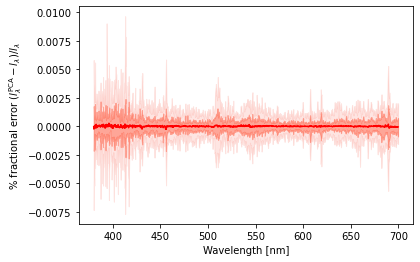

In [43]:
x = np.arange(3800, 7000, 2) / 10
plt.plot(x, np.median(diff, axis=0), color='r')
plt.fill_between(x, 
                 np.percentile(diff, (1 - norm.cdf(1)) * 100, axis=0), 
                 np.percentile(diff, norm.cdf(1) * 100, axis=0), alpha=0.5, color='tomato')

plt.fill_between(x, 
                 np.percentile(diff, (1 - norm.cdf(2)) * 100, axis=0), 
                 np.percentile(diff, norm.cdf(2) * 100, axis=0), alpha=0.2, color='salmon')

#plt.ylim(-0.008, 0.008)

plt.ylabel(r'% fractional error $(l_{\lambda}^{\mathrm{PCA}} - l_{\lambda})/l_{\lambda}$')
plt.xlabel('Wavelength [nm]')

Text(0.5, 0.98, 'PCA components')

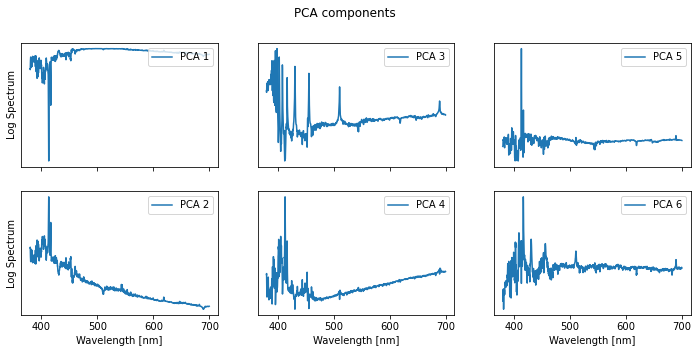

In [44]:
fig, axes = plt.subplots(2, 3, figsize=(12, 5), sharex=True)

x = np.arange(3800, 7000, 2) / 10

for i in range(6):
    ax = axes[i % 2, i // 2]
    ax.plot(x, PCABasis.PCA.components_[i], label=f'PCA {i + 1}')
    ax.set_yticks([])
    ax.legend(loc='upper right')

axes[0][0].set_ylabel('Log Spectrum')
axes[1][0].set_ylabel('Log Spectrum')

for k in range(3):
    axes[1][k].set_xlabel('Wavelength [nm]')
    
plt.suptitle('PCA components')

## Training

In [45]:
training_theta = tf.convert_to_tensor(PCABasis.training_parameters.astype(np.float32))
training_pca = tf.convert_to_tensor(PCABasis.training_pca.astype(np.float32))

In [47]:
training_theta

<tf.Tensor: shape=(1600, 2), dtype=float32, numpy=
array([[ 1.      , -2.      ],
       [ 1.      , -1.9     ],
       [ 1.      , -1.8     ],
       ...,
       [13.088109,  1.7     ],
       [13.088109,  1.8     ],
       [13.088109,  1.9     ]], dtype=float32)>

In [48]:
speculator = Speculator(n_parameters = 2, # number of model parameters 
                       wavelengths = 1600, # array of wavelengths
                       pca_transform_matrix = PCABasis.pca_transform_matrix, 
                       parameters_shift = PCABasis.parameter_shift, 
                       parameters_scale = PCABasis.parameter_scale, 
                       pca_shift = PCABasis.pca_shift, 
                       pca_scale = PCABasis.pca_scale, 
                       log_spectrum_shift = PCABasis.log_spectrum_shift, 
                       log_spectrum_scale = PCABasis.log_spectrum_scale, 
                       n_hidden = [256, 256, 256], # network architecture (list of hidden units per layer)
                       restore = False, 
                       restore_filename = None, # path + filename prefix for saving the model
                       optimizer = tf.keras.optimizers.Adam()) # optimizer for model training

In [49]:
from tqdm import trange

In [64]:
# cooling schedule
validation_split = 0.1
lr = [1e-2, 1e-3, 1e-4, 1e-5]
batch_size = [100, 100, 500, int((1-validation_split) * training_theta.shape[0])]
gradient_accumulation_steps = [1, 1, 1, 10] # split the largest batch size into 10 when computing gradients to avoid memory overflow

# early stopping set up
patience = 20
max_epochs = 200

# train using cooling/heating schedule for lr/batch-size
for i in range(len(lr)):

    print('learning rate = ' + str(lr[i]) + ', batch size = ' + str(batch_size[i]))

    # set learning rate
    speculator.optimizer.lr = lr[i]

    # split into validation and training sub-sets
    n_validation = int(training_theta.shape[0] * validation_split)
    n_training = training_theta.shape[0] - n_validation
    training_selection = tf.random.shuffle([True] * n_training + [False] * n_validation)

    # create iterable dataset (given batch size)
    training_data = tf.data.Dataset.from_tensor_slices((training_theta[training_selection], training_pca[training_selection])).shuffle(n_training).batch(batch_size[i])

    # set up training loss
    training_loss = [np.infty]
    validation_loss = [np.infty]
    best_loss = np.infty
    early_stopping_counter = 0

    # loop over epochs
    with trange(max_epochs) as t:
        
        for epoch in t:

            # loop over batches
            for theta, pca in training_data:

                # training step: check whether to accumulate gradients or not (only worth doing this for very large batch sizes)
                if gradient_accumulation_steps[i] == 1:
                    loss = speculator.training_step_pca(pca, theta)
                else:
                    loss = speculator.training_step_with_accumulated_gradients_pca(pca, theta, accumulation_steps=gradient_accumulation_steps[i])

            # compute validation loss at the end of the epoch
            validation_loss.append(speculator.compute_loss_pca(training_pca[~training_selection], training_theta[~training_selection]).numpy())

            # update the progressbar
            t.set_postfix(loss=validation_loss[-1])
            
#             # early stopping condition
#             if validation_loss[-1] < best_loss:
#                 best_loss = validation_loss[-1]
#                 early_stopping_counter = 0
#             else:
#                 early_stopping_counter += 1
#             if early_stopping_counter >= patience:
#                 speculator.update_emulator_parameters()
#                 speculator.save("model")
#                 print('Validation loss = ' + str(best_loss))
#                 break


learning rate = 0.01, batch size = 100


100%|██████████| 200/200 [00:19<00:00, 10.37it/s, loss=52.6]  


learning rate = 0.001, batch size = 100


100%|██████████| 200/200 [00:19<00:00, 10.36it/s, loss=7.05]


learning rate = 0.0001, batch size = 500


100%|██████████| 200/200 [00:07<00:00, 28.09it/s, loss=4.04]


learning rate = 1e-05, batch size = 1440


100%|██████████| 200/200 [00:20<00:00,  9.85it/s, loss=3.76]


In [52]:
params = np.load('./train_sed_backup/param_all.npy')
log_spec_all = np.load('./train_sed_backup/log_spec_all.npy')

In [65]:
theta = params[40]
spec = log_spec_all[40]
_spec = speculator.log_spectrum_(theta)

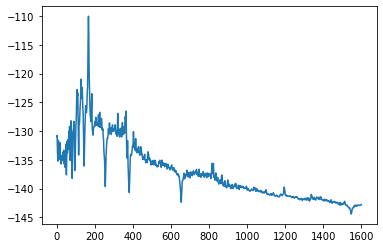

In [66]:
#plt.plot(spec)
plt.plot(_spec)